In [733]:
# Library Import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # for plot visualization
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import re

import warnings
# ignoring all the warnings
warnings.filterwarnings("ignore")

In [734]:
test_df = pd.read_csv('./test.csv')
train_df = pd.read_csv('./train.csv')
submission_df = pd.read_csv('./gender_submission.csv')

In [735]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [736]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [737]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [738]:
test_df.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* Observations:
    - Features like 'PassengerId' and 'Ticket' seems of no use, so we should remove them.
    - 'Age' and 'Fare' are of type float, so it will be better if we take their ceil value and convert them to integer.
    - 'Cabin' contains more than 77% of missing values, so it should get discarded because we are not expected to fill this many missing values on our own and even if we do then model will loose its significance.
    - From 'Name', we can create a new feature called 'Title' It may help model in performing better, not sure though, will see.
    - We have 'SibSp' and 'Parch' features which shows person's Siblings, Spouse, Parents and children. We can use this feature to come with two new features called 'FamilySize' and 'IsAlone'.
    - Newly created feature 'FamilySize' can be used to create a new feature called 'FarePerHead'.

In [739]:
# Handling Missing Values

def find_missing_record(df, type):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (total/df.isnull().count()).sort_values(ascending=False)
    missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'], sort=False)
    missing_df = missing_df[missing_df.Total > 0]
    
    plt.subplots(figsize=[12,5])
    plot_inst = sns.barplot(x=missing_df.index, y=missing_df.Total)
    plot_inst.set_title(f'{type} missing record count')
    
    return missing_df

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


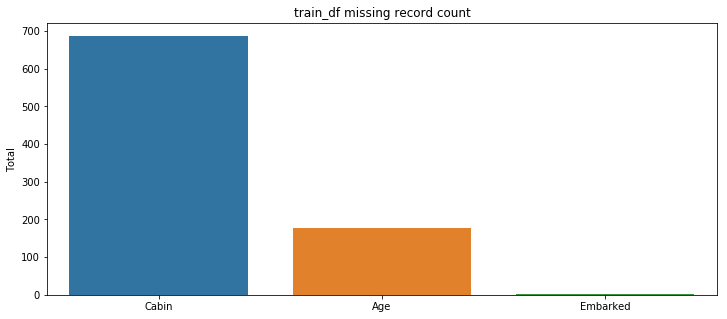

In [740]:
find_missing_record(train_df, 'train_df')

,Total,Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


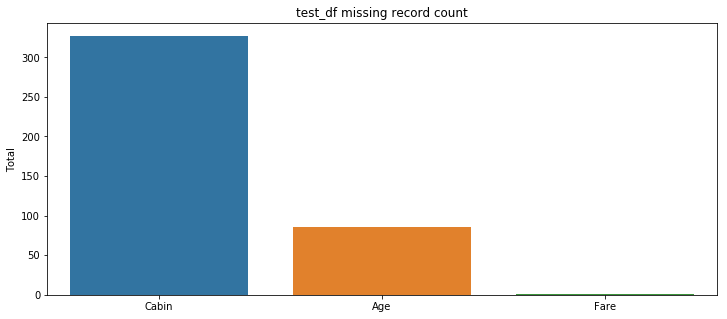

In [741]:
find_missing_record(test_df, 'test_df')

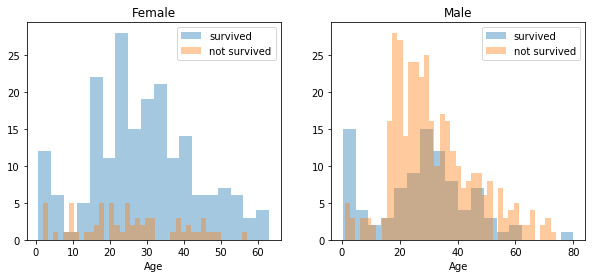

In [742]:

survived = 'survived'
not_survived = 'not survived'

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

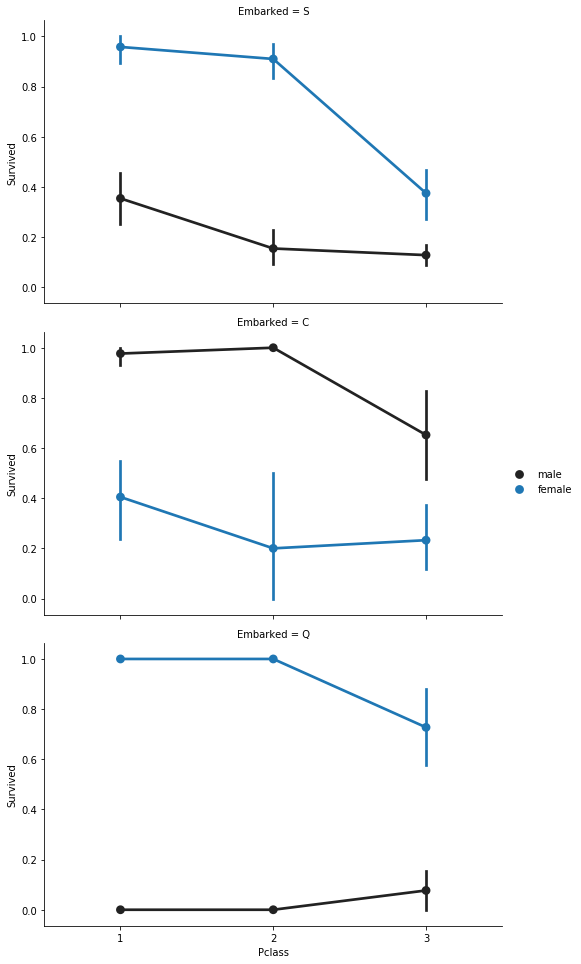

In [743]:
# Embarked, Pclass and Sex:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

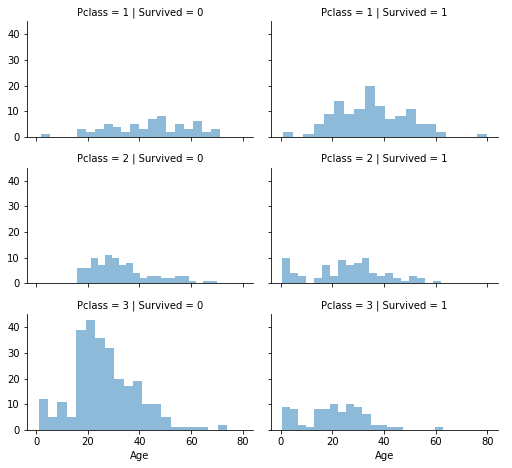

In [744]:
# PClass, Survival and Age Group

grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

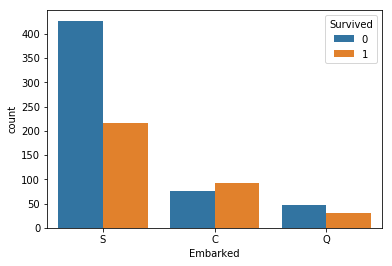

In [745]:
sns.countplot(x='Embarked', data=train_df, hue='Survived')

* Observations:
    - _Cabin_, _Age_, _Embarked_ and _Fare_ contains missing values.
    - _Cabin_ contains more than 77% missing values, So we should not consider this variable at all, because any assumed value can degrade the performance of our overall model.
    - To fill missing values in _Age_ and _Embarked_ we can consider MODE of all values.
    - To fill missing values in _Fare_, we can consder MEAN of all values.

In [746]:
def fill_missing_values(df):
    df.Age = np.ceil(df.Age.fillna(df.Age.median())).astype(int)
    df.Embarked = df.Embarked.fillna(df.Embarked.mode()[0])
    df.Fare = np.ceil(df.Fare.fillna(df.Fare.mean())).astype(int)

    return df

In [747]:
test_df = fill_missing_values(test_df)
train_df = fill_missing_values(train_df)

In [748]:
# Creating new feature FamilySize
train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1
test_df['FamilySize'] = test_df.SibSp + test_df.Parch + 1

In [749]:
# Creating new feature FarePerHead
train_df['FarePerHead'] = (train_df.Fare/train_df.FamilySize).astype(int)
test_df['FarePerHead'] = (test_df.Fare/test_df.FamilySize).astype(int)

In [750]:
# Creating new feature 'IsAlone'
train_df['IsAlone'] = train_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
test_df['IsAlone'] = test_df.FamilySize.apply(lambda x: 1 if x==1 else 0)

In [751]:
# Create new feature 'AgeGroup'
train_df['AgeGroup'] = train_df.Age.apply(lambda x: 'kid' if x<13 else 'teen' if x<20 else 'adult' if x<41 else 'old')
test_df['AgeGroup'] = test_df.Age.apply(lambda x: 'kid' if x<13 else 'teen' if x<20 else 'adult' if x<41 else 'old')

In [752]:
# Create new feature called Title
def add_title(df):
    df['Title'] = df.Name.apply(lambda x: re.search('(?<=, )\w+', x).group(0))
    df.Title.replace(to_replace=['Ms', 'Lady', 'the', 'Dona'], value='Mrs', inplace=True)
    df.Title.replace(to_replace=['Mme', 'Mlle'], value='Miss', inplace=True)
    df.Title.replace(to_replace=['Jonkheer', 'Sir', 'Capt', 'Don', 'Col', 'Major', 'Rev', 'Dr'], value='Mr', inplace=True)
    return df

In [753]:
train_df = add_title(train_df)
test_df = add_title(test_df)

In [754]:
# Handle Categorical variables
def handle_categorical_variables(df):
    df = pd.get_dummies(df, drop_first=True, columns=['Sex', 'Embarked'])
    df.AgeGroup = LabelEncoder().fit_transform(df.AgeGroup)
    df.Title = LabelEncoder().fit_transform(df.Title)
    return df

In [755]:
train_df = handle_categorical_variables(train_df)
test_df = handle_categorical_variables(test_df)

In [756]:
train_df.drop(labels=['PassengerId','Name','Ticket', 'Cabin'], axis=1, inplace=True)
test_df.drop(labels=['PassengerId','Name','Ticket', 'Cabin'], axis=1, inplace=True)

In [757]:
# def distplot(value, **kwargs):
#     sns.distplot(value, color='teal', label=f'skewness: {value.skew()}')
#     plt.legend()
#     plt.xticks(rotation=90)

# melted_df = pd.melt(train_df, value_vars = train_df.columns.values)
# facet_grid_df = sns.FacetGrid(melted_df, col='variable', col_wrap=4, sharex=False, sharey = False, height=5)
# facet_grid_df.map(distplot, 'value')

In [758]:
train_df.sample(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,FarePerHead,IsAlone,AgeGroup,Title,Sex_male,Embarked_Q,Embarked_S
218,1,1,32,0,0,77,1,77,1,0,1,0,0,0
557,0,1,28,0,0,228,1,228,1,0,2,1,0,0
565,0,3,24,2,0,25,3,8,0,0,2,1,0,1
383,1,1,35,1,0,52,2,26,0,0,3,0,0,1
192,1,3,19,1,0,8,2,4,0,3,1,0,0,1
261,1,3,3,4,2,32,7,4,0,1,0,1,0,1
388,0,3,28,0,0,8,1,8,1,0,2,1,1,0
345,1,2,24,0,0,13,1,13,1,0,1,0,0,1
470,0,3,28,0,0,8,1,8,1,0,2,1,0,1
584,0,3,28,0,0,9,1,9,1,0,2,1,0,0


In [759]:
# global random_state value
rand_state_ = 42
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Survived'], axis=1), train_df.Survived, test_size=0.3, random_state=rand_state_)

In [760]:
class EvaluateClassifier():
    def __init__(self):
        self.classifiers = {}

    def evaluate_model(self, modelName, train_predictions, test_predictions):
        self.classifiers[modelName] = {
            'train_score': accuracy_score(y_train, train_predictions),            
            'test_score': accuracy_score(y_test, test_predictions)
        }

    def fit_and_predict_using_RandomSearchCV(self, classifier, grid_params):
        random_cv_model = RandomizedSearchCV(estimator=classifier, param_distributions=grid_params, cv=10)
        random_cv_model.fit(X_train, y_train)
        self.evaluate_model(classifier.__class__.__name__, random_cv_model.predict(X_train), random_cv_model.predict(X_test))
        self.classifiers[classifier.__class__.__name__]['estimator'] = random_cv_model.estimator
        return self.classifiers[classifier.__class__.__name__]

    def voting_classifier(self, classifier_names):
        selected_classifiers = [(classifier_name, self.classifiers[classifier_name]['estimator']) for classifier_name in classifier_names]
        voting_classifier = VotingClassifier(estimators=selected_classifiers, voting='soft')
        voting_classifier.fit(X_train, y_train)
        self.evaluate_model(voting_classifier.__class__.__name__, voting_classifier.predict(X_train), voting_classifier.predict(X_test))
        self.classifiers[voting_classifier.__class__.__name__]['estimator'] = voting_classifier
        return self.classifiers[voting_classifier.__class__.__name__]

In [761]:
eval_classifier = EvaluateClassifier()

In [762]:
# Decision Tree
dt_grid_param = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt'],
    'random_state': [rand_state_]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(DecisionTreeClassifier(), dt_grid_param)

{'train_score': 0.8202247191011236,
 'test_score': 0.8022388059701493,
 'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best')}

In [763]:
# Random Forest
rf_grid_param = {
    'n_estimators': [10, 30, 60, 90, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4],
    'min_samples_split': [2, 3, 4],
    'max_features': ['sqrt'],
    'random_state': [rand_state_]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(RandomForestClassifier(), rf_grid_param)

{'train_score': 0.8539325842696629,
 'test_score': 0.8208955223880597,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)}

In [764]:
# XGboost Classifier
xgb_grid_param = {
    'max_depth': [3, 4, 5],
    'learning_rate': [.1, .06, .03, .01],
    'n_estimators': [80, 100, 120],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'gamma': [0, 2, 4],
    'random_state': [rand_state_]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(XGBClassifier(), xgb_grid_param)

{'train_score': 0.869983948635634,
 'test_score': 0.8134328358208955,
 'estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1)}

In [765]:
# sns.barplot(x=train_df.drop(['Survived'], axis=1).columns, y=rf_classifier.feature_importances_)

In [766]:
# K nearest neighbors
knn_grid_params = {
    'n_neighbors': [5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

eval_classifier.fit_and_predict_using_RandomSearchCV(KNeighborsClassifier(), knn_grid_params)

{'train_score': 0.7913322632423756,
 'test_score': 0.7276119402985075,
 'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform')}

In [767]:
# ExtraTreesClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(ExtraTreesClassifier(), {
    'n_estimators': [20, 40, 80],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt']
})

{'train_score': 0.9470304975922953,
 'test_score': 0.7985074626865671,
 'estimator': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False)}

In [768]:
# RidgeClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(RidgeClassifier(), {
    'alpha': [0.8, 1, 7, 13, 17],
    'random_state': [rand_state_]
})

{'train_score': 0.797752808988764,
 'test_score': 0.7985074626865671,
 'estimator': RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
         max_iter=None, normalize=False, random_state=None, solver='auto',
         tol=0.001)}

In [769]:
# RidgeClassifierCV
eval_classifier.fit_and_predict_using_RandomSearchCV(RidgeClassifierCV(cv=10), {
    'alphas': [(0.05, 0.1, 0.5, 1, 2)]
})

{'train_score': 0.797752808988764,
 'test_score': 0.7985074626865671,
 'estimator': RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=10,
          fit_intercept=True, normalize=False, scoring=None,
          store_cv_values=False)}

In [770]:
# LogisticRegression
# eval_classifier.fit_and_predict_using_RandomSearchCV(LogisticRegression(), {
#     'C': [0.5, 1.0, 1,5],
#     'random_state': [rand_state_],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [50, 100, 150],
#     'multi_class': ['auto'],
#     'warm_start': [True]
# })

In [771]:
# LogisticRegressionCV
# eval_classifier.fit_and_predict_using_RandomSearchCV(LogisticRegressionCV(cv=10), {
#     'Cs': [1, 2, 4],
#     'random_state': [rand_state_],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [20, 30, 50, 100],
#     'multi_class': ['auto']
# })

In [772]:
# AdaBoostClassifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=1, min_samples_split=3, random_state=rand_state_, splitter='best')
xgb_classifier = XGBClassifier(booster='dart', gamma=2, learning_rate=0.1, max_depth=3, n_estimators=100, random_state=rand_state_)

eval_classifier.fit_and_predict_using_RandomSearchCV(AdaBoostClassifier(), {
    'base_estimator': [dt_classifier, xgb_classifier],
    'n_estimators': [50, 70, 90],
    'random_state': [rand_state_],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.8, 1.0, 1.3]
})

{'train_score': 0.9646869983948636,
 'test_score': 0.7574626865671642,
 'estimator': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None)}

In [773]:
# BaggingClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(BaggingClassifier(), {
    'base_estimator': [dt_classifier, xgb_classifier],
    'n_estimators': [10, 20, 30],
    'random_state': [rand_state_],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
})

{'train_score': 0.8523274478330658,
 'test_score': 0.8208955223880597,
 'estimator': BaggingClassifier(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
          verbose=0, warm_start=False)}

In [774]:
# GradientBoostingClassifier
eval_classifier.fit_and_predict_using_RandomSearchCV(GradientBoostingClassifier(), {
    'loss': ['deviance', 'exponential'],
    'n_estimators': [100, 120, 150],
    'random_state': [rand_state_],
    'min_samples_split': [2, 3, 4],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4]
})

{'train_score': 0.9309791332263242,
 'test_score': 0.8134328358208955,
 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               n_iter_no_change=None, presort='auto', random_state=None,
               subsample=1.0, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False)}

In [775]:
# Voting Classifier
voting_classifier = eval_classifier.voting_classifier(['RandomForestClassifier', 'AdaBoostClassifier'])
voting_classifier

{'train_score': 0.956661316211878,
 'test_score': 0.8059701492537313,
 'estimator': VotingClassifier(estimators=[('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2...m='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None))],
          flatten_transform=None, n_jobs=None, voting='soft', weights=None)}

In [776]:
score_df = pd.DataFrame([{'ModelName': name, 'Test Score': props['test_score'], 'Training Score': props['train_score']} for name, props in eval_classifier.classifiers.items()])
score_df.set_index('ModelName')

,Test Score,Training Score
ModelName,,
DecisionTreeClassifier,0.802239,0.820225
RandomForestClassifier,0.820896,0.853933
XGBClassifier,0.813433,0.869984
KNeighborsClassifier,0.727612,0.791332
ExtraTreesClassifier,0.798507,0.947030
RidgeClassifier,0.798507,0.797753
RidgeClassifierCV,0.798507,0.797753
AdaBoostClassifier,0.757463,0.964687
BaggingClassifier,0.820896,0.852327


In [777]:
# submission_df.Survived = voting_classifier['Estimator'].predict(test_df)
# submission_df.to_csv("./new_submission.csv", index=False)